In [1]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from scipy import signal
import os
import sys

## Load measurement data

In [2]:
def readBonsai(path):
    bonsai = pd.read_csv(path)
    bonsai = bonsai[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']]
    return bonsai
    
def readEXLS3(path):
    exl = pd.read_fwf(path)
    exl.columns = exl.iloc[2]
    exl = exl[['a_x [g]:', 'a_y [g]:', 'a_z [g]:', 'ar_x [rad/s]:', 'ar_y [rad/s]:', 'ar_z [rad/s]:']]
    exl.rename(index=str, columns={
        'a_x [g]:': 'accX', 'a_y [g]:': 'accY', 'a_z [g]:': 'accZ', 
        'ar_x [rad/s]:': 'gyrX', 'ar_y [rad/s]:': 'gyrY', 'ar_z [rad/s]:': 'gyrZ'
    }, inplace=True)
    exl = exl.iloc[3:]
    exl.reset_index(drop=True, inplace=True)
    exl = exl.apply(pd.to_numeric)
    exl = exl.multiply(9.80665)
    return exl

def tagColumnNames(df, tag):
    newColumnNames = {columnName: columnName + tag for columnName in df.columns}
    return df.rename(index=int, columns=newColumnNames)


fileNameLocationMap = {
    'I-L9H': 'hip-r',
    'I-74V': 'hip-l',
    'I-WXB': 'knee-r',
    'I-0GN': 'knee-l',
    'Gait - R': 'foot-r',
    'Gait - L': 'foot-l'
}
def mapFileNameToLocation(fileName):
    for name, location in fileNameLocationMap.items():
        if (name in fileName):
            return location
    return 'unknown'

def loadMeasurements(path):
    measurements = {}
    for fileOrDir in os.listdir(path):
        if (fileOrDir.endswith('.txt')):
            measurement = readEXLS3(os.path.join(path, fileOrDir))
        elif (fileOrDir.endswith('.csv')):
            measurement = readBonsai(os.path.join(path, fileOrDir))
        if (measurement is not None):
            measurementLocation = mapFileNameToLocation(fileOrDir)
            measurement = tagColumnNames(measurement, '_' + measurementLocation)
            measurements[measurementLocation] = measurement
    return measurements

## Synchronize the sensor data

In [3]:
numberOfJumps = 3
binSize = 50 # 10ms * binSize = time per bin; bundles neighbor values to avoid multiple amplitudes during same jump

def findJumpingWindow(measurement):
    absMeasurement = measurement.abs()
    bins = absMeasurement.groupby(pd.cut(absMeasurement.index, np.arange(0, len(measurement), binSize))).max()    
    jumpIndicies = list(bins.nlargest(numberOfJumps).sort_index().index)
    lowerBound, upperBound = jumpIndicies[0].left, jumpIndicies[numberOfJumps - 1].right
    return lowerBound - 100, upperBound + 100

In [17]:
def alignSignals(dfX, dfY):
    windowIndiciesDFX = findJumpingWindow(dfX)
    windowIndiciesDFY = findJumpingWindow(dfY)
    windowDFX = dfX[windowIndiciesDFX[0]:windowIndiciesDFX[1]]
    windowDFY = dfY[windowIndiciesDFY[0]:windowIndiciesDFY[1]]
    
    amplitudeOffset = np.argmax(windowDFX.values) - np.argmax(windowDFY.values)    
    windowOffset = windowIndiciesDFX[0] - windowIndiciesDFY[0]
    return amplitudeOffset + windowOffset

def alignAccelerationYWithRightFoot(measurements, location, axis):
    offset = alignSignals(
        measurements['foot-r']['accY_foot-r'], 
        measurements[location]['acc' + axis.upper() + '_' + location])
    measurements[location] = measurements[location].shift(offset, axis='index')

## Combine loading with sync

In [18]:
def loadSyncedMeasurements(path):
    measurements = loadMeasurements(path)
    alignAccelerationYWithRightFoot(measurements, 'hip-r', 'y')
    alignAccelerationYWithRightFoot(measurements, 'hip-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'foot-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-r', 'Y')
    merged = pd.DataFrame()
    for measurement in measurements.values():
        merged = merged.join(measurement, how='outer')
    return merged

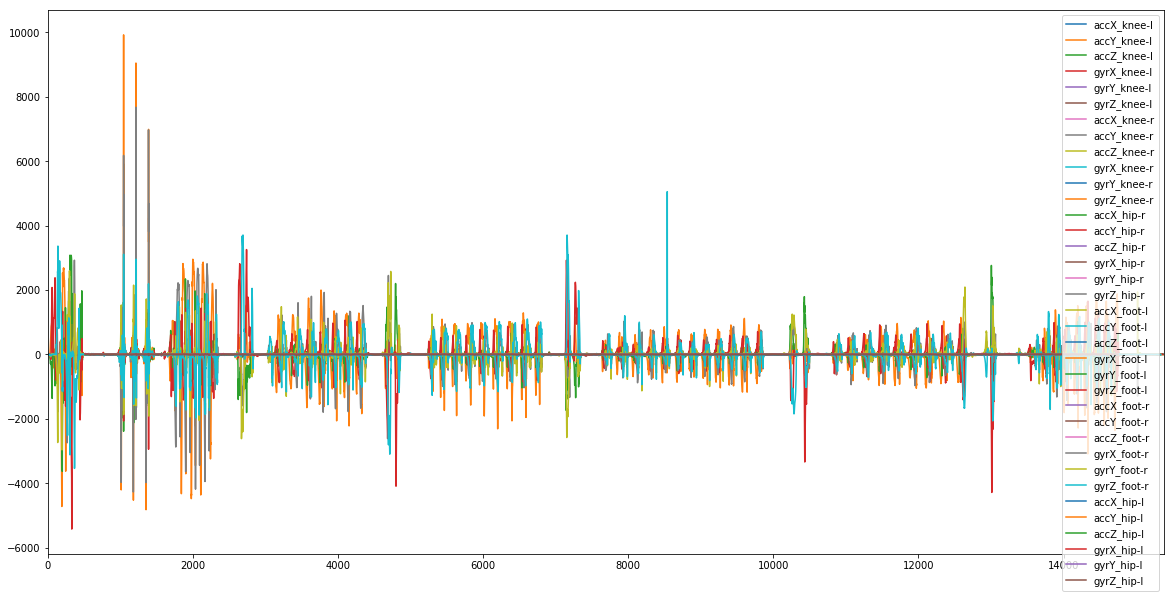

In [19]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'martin 1')).plot(figsize=(20, 10))

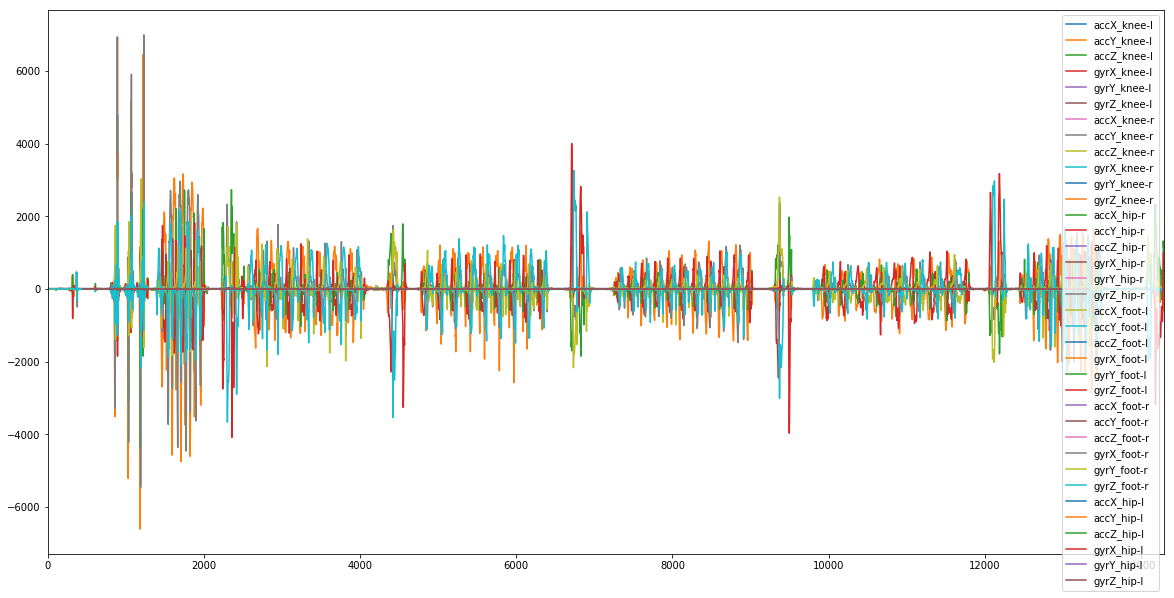

In [21]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'martin 2')).plot(figsize=(20, 10))

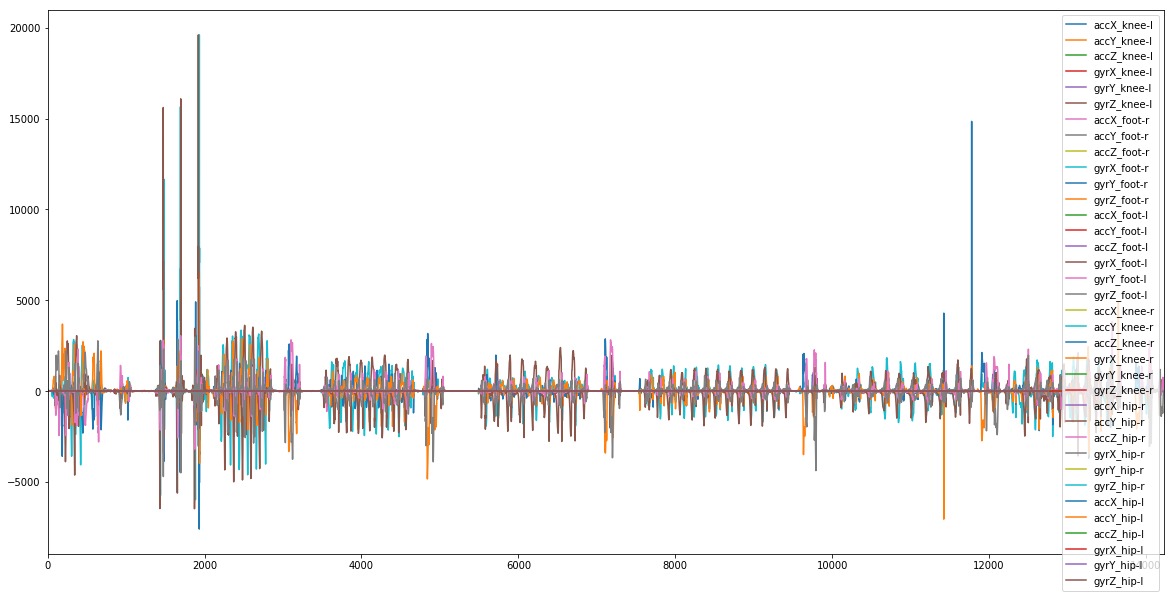

In [11]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'leonardo 1')).plot(figsize=(20, 10))

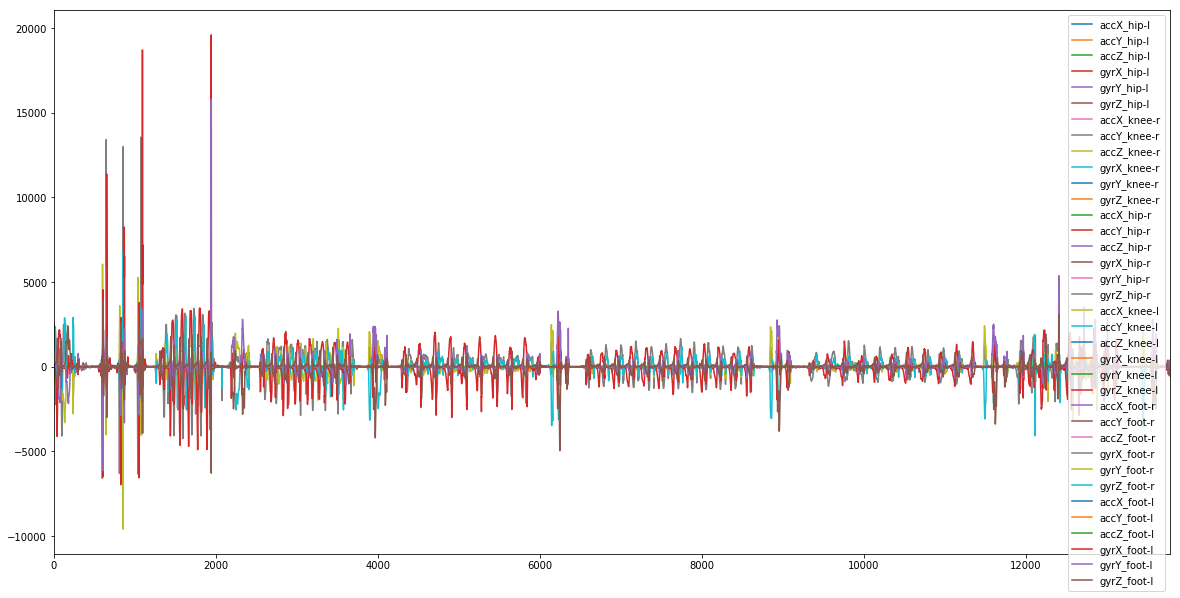

In [12]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'leonardo 2')).plot(figsize=(20, 10))

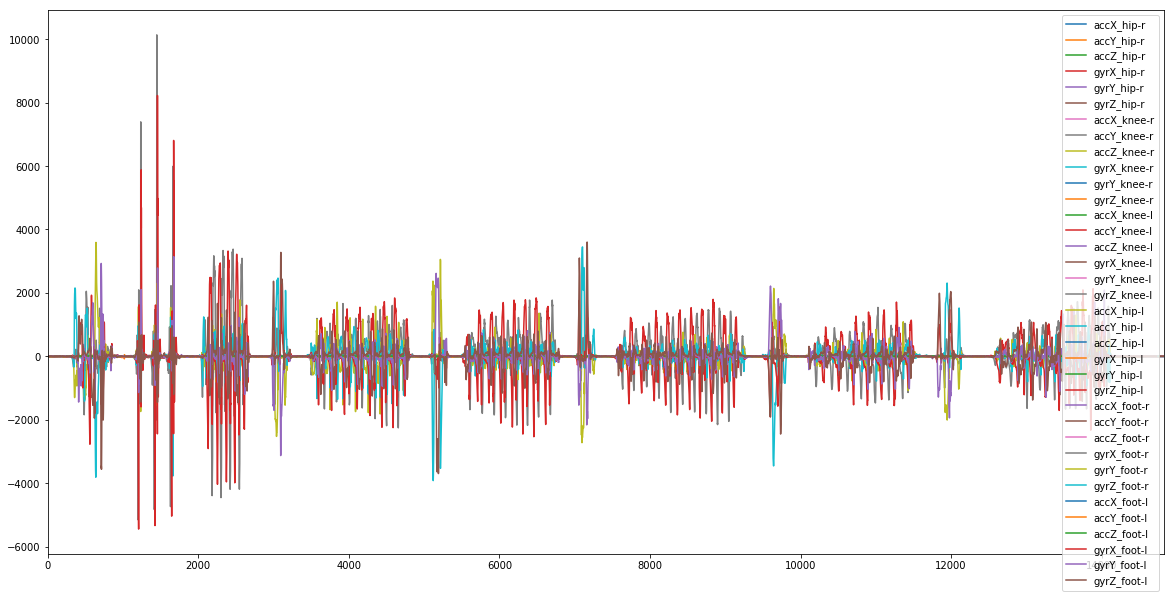

In [14]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'dennis 1')).plot(figsize=(20, 10))

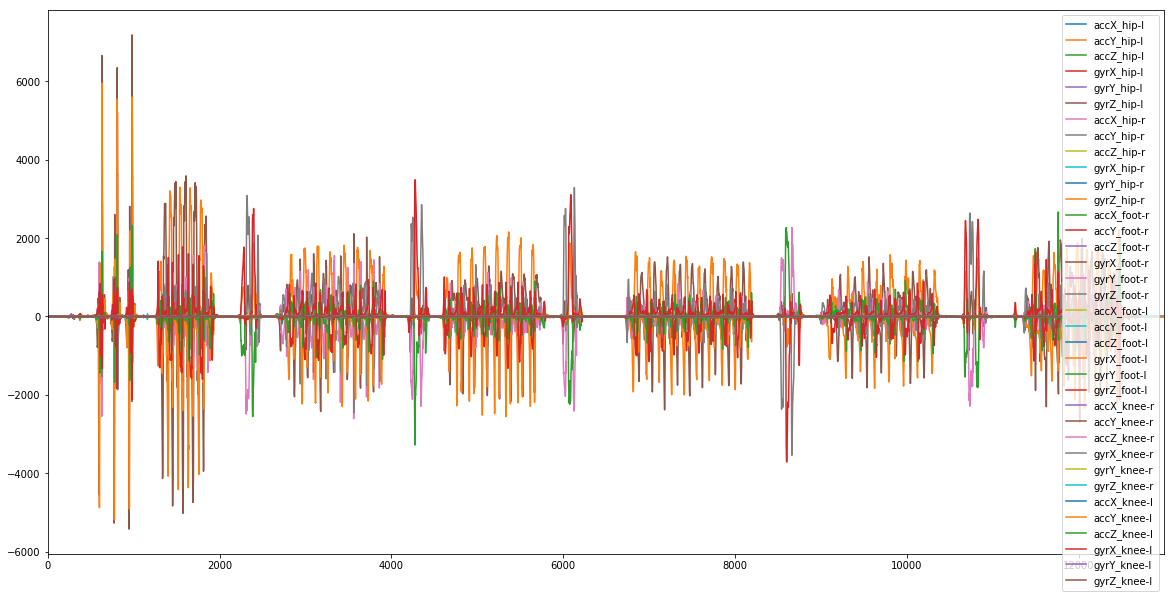

In [15]:
loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'dennis 2')).plot(figsize=(20, 10))

## Analyze measure by measure

In [34]:
exampleDataset = loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'martin 2'))
exampleDataset.columns

Index(['accX_knee-l', 'accY_knee-l', 'accZ_knee-l', 'gyrX_knee-l',
       'gyrY_knee-l', 'gyrZ_knee-l', 'accX_knee-r', 'accY_knee-r',
       'accZ_knee-r', 'gyrX_knee-r', 'gyrY_knee-r', 'gyrZ_knee-r',
       'accX_hip-r', 'accY_hip-r', 'accZ_hip-r', 'gyrX_hip-r', 'gyrY_hip-r',
       'gyrZ_hip-r', 'accX_foot-l', 'accY_foot-l', 'accZ_foot-l',
       'gyrX_foot-l', 'gyrY_foot-l', 'gyrZ_foot-l', 'accX_foot-r',
       'accY_foot-r', 'accZ_foot-r', 'gyrX_foot-r', 'gyrY_foot-r',
       'gyrZ_foot-r', 'accX_hip-l', 'accY_hip-l', 'accZ_hip-l', 'gyrX_hip-l',
       'gyrY_hip-l', 'gyrZ_hip-l'],
      dtype='object')

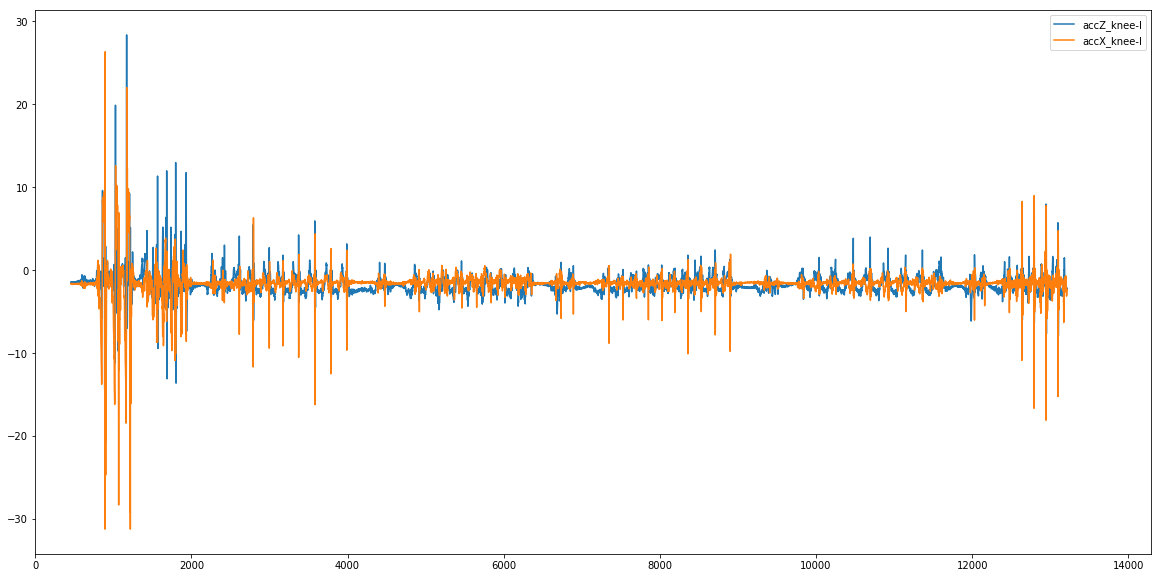

In [67]:
exampleDataset['accX_knee-l']=exampleDataset['accX_knee-l'] - 1
exampleDataset[['accZ_knee-l', 'accX_knee-l']].plot(figsize=(20, 10))